**SAC** **Implementation**

In [2]:
!pip install stable-baselines3[extra] grid2op lightsim2grid


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 80.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 35.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.8/853.8 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.7 MB/s eta 0:00:00
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install gymnasium


In [ ]:
import grid2op
import gymnasium as gym
import numpy as np
from grid2op import gym_compat
from lightsim2grid import LightSimBackend
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

class Gym2OpEnv(gym.Env):
    """
    Custom Gym environment for the Grid2Op simulation.
    This environment uses the LightSimBackend to simulate power grid dynamics.

    Attributes:
    _backend (LightSimBackend): Backend to run the simulation.
    _env_name (str): Name of the Grid2Op environment to use.
    _g2op_env (grid2op.Environment): Instance of the Grid2Op environment.
    observation_space (gym.spaces.Dict): The observation space of the environment.
    action_space (gym.spaces.Box): The action space of the environment.
    """

    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        # Set parameters for the environment
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Create the Grid2Op environment with specified parameters
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        # Setup combined rewards
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        # Create the Gym-compatible environment
        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        # Define observation and action spaces
        self.observation_space = self.setup_observations()
        self.action_space = self.setup_actions()

    def setup_observations(self):
        """
        Sets up the observation space by filtering the original observation keys.

        Returns:
        gym.spaces.Dict: The filtered observation space.
        """
        original_obs_space = self._gym_env.observation_space
        print("Keys in Original Observation Space:", original_obs_space.spaces.keys())

        # Create a filtered observation space using available keys
        filtered_observation_space = gym.spaces.Dict({
            '_shunt_bus': gym.spaces.Box(low=0, high=1, shape=(original_obs_space.spaces['_shunt_bus'].shape[0],), dtype=np.float32),
            '_shunt_p': gym.spaces.Box(low=0, high=1, shape=(original_obs_space.spaces['_shunt_p'].shape[0],), dtype=np.float32),
            '_shunt_q': gym.spaces.Box(low=0, high=1, shape=(original_obs_space.spaces['_shunt_q'].shape[0],), dtype=np.float32),
            '_shunt_v': gym.spaces.Box(low=0, high=1, shape=(original_obs_space.spaces['_shunt_v'].shape[0],), dtype=np.float32),
        })

        return filtered_observation_space

    def setup_actions(self):
        """
        Sets up the action space for the environment.

        Returns:
        gym.spaces.Box: The action space of the environment.
        """
        return self._gym_env.action_space

    def reset(self, seed=None):
        """
        Resets the environment to an initial state.

        Parameters:
        seed (int, optional): Random seed for reproducibility.

        Returns:
        numpy.ndarray: Initial observation.
        """
        return self._gym_env.reset(seed=seed, options=None)

    def step(self, action):
        """
        Executes a given action in the environment.

        Parameters:
        action (numpy.ndarray): Action to be taken.

        Returns:
        tuple: (next_observation, reward, done, info)
        """
        return self._gym_env.step(action)

    def render(self):
        """
        Renders the current state of the environment.
        """
        return self._gym_env.render()


class ActionWrapper(gym.ActionWrapper):
    """
    Wrapper class to modify actions before they are sent to the environment.
    """

    def __init__(self, env):
        super(ActionWrapper, self).__init__(env)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(100,), dtype=np.float32)

    def action(self, act):
        """
        Converts raw action vector to structured action.

        Parameters:
        act (numpy.ndarray): Raw action vector.

        Returns:
        dict: Structured action with specified changes.
        """
        dict_action = {
            'change_bus': np.where(act[:57] > 0, 1, 0).astype(int),
            'change_line_status': np.where(act[57:77] > 0, 1, 0).astype(int),
            'curtail': act[77:83],
            'redispatch': act[83:89]
        }
        return dict_action

    def reset(self, seed=None):
        return self.env.reset(seed=seed)


# Main execution starts here
if __name__ == "__main__":
    # Initialize the custom Grid2Op environment
    env = Gym2OpEnv()
    wrapped_env = ActionWrapper(env)  # Wrap the environment

    # Initialize the SAC model
    from stable_baselines3 import SAC
    from stable_baselines3.common.evaluation import evaluate_policy

    sac_model = SAC(
        "MultiInputPolicy",  # Use MultiInputPolicy for Dict observations
        wrapped_env,         # The wrapped environment
        learning_rate=0.0003,
        buffer_size=1000000,
        batch_size=256,
        tau=0.005,
        gamma=0.99,
        train_freq=1,
        verbose=1,
        device="cuda"  # Use "cpu" if CUDA isn't available
    )

    # Train the SAC model
    sac_model.learn(total_timesteps=100000)

    # Evaluate the trained model
    mean_reward, std_reward = evaluate_policy(sac_model, wrapped_env, n_eval_episodes=10)
    print(f"Mean reward: {mean_reward} ± {std_reward}")

    # Save the trained model
    sac_model.save("sac_grid2op_agent")


/usr/local/lib/python3.10/dist-packages/grid2op/MakeEnv/Make.py:506: UserWarning: It is the first time you use the environment "l2rpn_case14_sandbox".
We will attempt to download this environment from remote
  warnings.warn(_MAKE_FIRST_TIME_WARN.format(dataset_name))


downloading the training data, this may take a while.


l2rpn_case14_sandbox.tar.bz2: 294MB [00:30, 9.53MB/s]                           


Extract the tar archive in "/root/data_grid2op"
	 Successfully updated file "config.py" for environment "l2rpn_case14_sandbox"
	 Successfully updated file "grid.json" for environment "l2rpn_case14_sandbox"
You may now use the environment "l2rpn_case14_sandbox" with the available data by invoking:
	env = grid2op.make("l2rpn_case14_sandbox")
Keys in Original Observation Space: odict_keys(['_shunt_bus', '_shunt_p', '_shunt_q', '_shunt_v', 'a_ex', 'a_or', 'actual_dispatch', 'attention_budget', 'current_step', 'curtailment', 'curtailment_limit', 'curtailment_limit_effective', 'day', 'day_of_week', 'delta_time', 'duration_next_maintenance', 'gen_margin_down', 'gen_margin_up', 'gen_p', 'gen_p_before_curtail', 'gen_q', 'gen_theta', 'gen_v', 'hour_of_day', 'is_alarm_illegal', 'line_status', 'load_p', 'load_q', 'load_theta', 'load_v', 'max_step', 'minute_of_hour', 'month', 'p_ex', 'p_or', 'q_ex', 'q_or', 'rho', 'target_dispatch', 'thermal_limit', 'theta_ex', 'theta_or', 'time_before_cooldown_lin

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.17e+03 |
|    ep_rew_mean     | 715      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 21       |
|    time_elapsed    | 410      |
|    total_timesteps | 8699     |
| train/             |          |
|    actor_loss      | -722     |
|    critic_loss     | 4.09     |
|    ent_coef        | 0.0762   |
|    ent_coef_loss   | -418     |
|    learning_rate   | 0.0003   |
|    n_updates       | 8598     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.1e+03  |
|    ep_rew_mean     | 694      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 21       |
|    time_elapsed    | 791      |
|    total_timesteps | 16814    |
| train/             |

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 465.82884995639324 ± 503.96680304843693


In [ ]:
from google.colab import files
# Download the saved SAC model
files.download("sac_grid2op_agent.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reset the environment and get the initial observation
obs, info = wrapped_env.reset()

# Print the structure of the initial observation
print("Initial Observation:", obs)


Initial Observation: OrderedDict([('_shunt_bus', array([1], dtype=int32)), ('_shunt_p', array([0.], dtype=float32)), ('_shunt_q', array([-21.095509], dtype=float32)), ('_shunt_v', array([21.074059], dtype=float32)), ('a_ex', array([ 176.94003 ,  163.40819 ,  102.636185,  173.89534 ,  146.90237 ,
         79.565796,  122.93627 ,  376.25452 ,  258.6762  ,  640.0516  ,
        109.081154,  245.93799 ,  263.06815 ,   72.169205,  283.3271  ,
       1237.9451  ,  426.3825  , 1029.0735  , 1094.6862  , 1055.7369  ],
      dtype=float32)), ('a_or', array([184.01225 , 163.44022 , 106.985214, 173.50618 , 146.65558 ,
        77.00579 , 122.93627 , 376.25452 , 258.6762  , 640.0516  ,
       109.081154, 245.93799 , 263.06815 ,  72.169205, 283.3271  ,
       128.41374 ,  63.77148 , 160.02261 , 938.30237 , 739.0158  ],
      dtype=float32)), ('actual_dispatch', array([0., 0., 0., 0., 0., 0.], dtype=float32)), ('attention_budget', array([0.], dtype=float32)), ('current_step', array([0], dtype=int32)), 

In [4]:
import gymnasium as gym
import grid2op
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import CombinedScaledReward, N1Reward, L2RPNReward  # Import N1Reward, L2RPNReward
from lightsim2grid import LightSimBackend

class Gym2OpEnv(gym.Env):
    """
    Custom Gym environment for the Grid2Op simulation.
    This environment uses the LightSimBackend to simulate power grid dynamics.

    Attributes:
    _backend (LightSimBackend): Backend to run the simulation.
    _env_name (str): Name of the Grid2Op environment to use.
    _g2op_env (grid2op.Environment): Instance of the Grid2Op environment.
    observation_space (gym.spaces.Dict): The observation space of the environment.
    action_space (gym.spaces.Box): The action space of the environment.
    """

    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        # Set parameters for the environment
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Create the Grid2Op environment with specified parameters
        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        # Setup combined rewards
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        # Create the Gym-compatible environment
        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        # Define observation and action spaces
        self.observation_space = self._gym_env.observation_space
        self.action_space = self._gym_env.action_space

    def reset(self, seed=None, options=None):
        """
        Resets the environment to an initial state.

        Parameters:
        seed (int, optional): Random seed for reproducibility.

        Returns:
        numpy.ndarray: Initial observation.
        """
        return self._gym_env.reset(seed=seed)

    def step(self, action):
        """
        Executes a given action in the environment.

        Parameters:
        action (numpy.ndarray): Action to be taken.

        Returns:
        tuple: (next_observation, reward, done, info)
        """
        return self._gym_env.step(action)

    def render(self):
        """
        Renders the current state of the environment.
        """
        return self._gym_env.render()


class ActionWrapper(gym.ActionWrapper):
    """
    Wrapper class to modify actions before they are sent to the environment.
    """

    def __init__(self, env):
        super().__init__(env)
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(89,), dtype=np.float32)

    def action(self, act):
        """
        Converts raw action vector to structured action.

        Parameters:
        act (numpy.ndarray): Raw action vector.

        Returns:
        dict: Structured action with specified changes.
        """
        return {
            'change_bus': np.where(act[:57] > 0, 1, 0).astype(int),
            'change_line_status': np.where(act[57:77] > 0, 1, 0).astype(int),
            'curtail': act[77:83],
            'redispatch': act[83:89]
        }


# Initialize the custom Grid2Op environment
env = Gym2OpEnv()
wrapped_env = ActionWrapper(env)

# Initialize the SAC model
sac_model = SAC(
    "MultiInputPolicy",
    wrapped_env,
    learning_rate=0.0003,
    buffer_size=1000000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    verbose=1,
    device="cuda"
)

# Train the SAC model
sac_model.learn(total_timesteps=100000)

# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(sac_model, wrapped_env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} ± {std_reward}")

#Save trained model
sac_model.save("sac_grid2op_agent_v2")


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/grid2op/MakeEnv/Make.py:506: UserWarning: It is the first time you use the environment "l2rpn_case14_sandbox".
We will attempt to download this environment from remote
  warnings.warn(_MAKE_FIRST_TIME_WARN.format(dataset_name))


downloading the training data, this may take a while.


l2rpn_case14_sandbox.tar.bz2: 294MB [00:33, 8.87MB/s]                           


Extract the tar archive in "/root/data_grid2op"
	 Successfully updated file "config.py" for environment "l2rpn_case14_sandbox"
	 Successfully updated file "grid.json" for environment "l2rpn_case14_sandbox"
You may now use the environment "l2rpn_case14_sandbox" with the available data by invoking:
	env = grid2op.make("l2rpn_case14_sandbox")
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.24e+03 |
|    ep_rew_mean     | 410      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 35       |
|    time_elapsed    | 137      |
|    total_timesteps | 4948     |
| train/             |          |
|    actor_loss      | -591     |
|    critic_loss     | 5.75     |
|    ent_coef        | 0.266    |
|    ent_coef_loss   | -186     |
|    learning_rate   | 0.0003   |
|    n_updates       | 4847     |
-------------------

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 621.8216163381934 ± 470.15009419773355


In [5]:
sac_model.save("sac_grid2op_agent_v2")


In [ ]:
from google.colab import files
# Download the saved SAC model
files.download("sac_grid2op_agent_v2.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Load the trained model
sac_model = SAC.load("sac_grid2op_agent_v2")

# Reset the environment
obs, info = wrapped_env.reset()

# Run the agent in the environment for a specified number of steps
for step in range(1000):
    action, _states = sac_model.predict(obs, deterministic=True)
    step_result = wrapped_env.step(action)
    obs, reward, done, info = step_result[:4]
    if done:
        obs, info = wrapped_env.reset()  # Reset if done

In [7]:
# Reset the environment
obs, info = wrapped_env.reset()
total_reward = 0
n_episodes = 10  # Number of episodes to evaluate
rewards = []  # List to store rewards for each episode

for episode in range(n_episodes):
    obs, info = wrapped_env.reset()  # Reset the environment for a new episode
    episode_reward = 0
    done = False

    while not done:
        action, _ = sac_model.predict(obs, deterministic=True)
        step_result = wrapped_env.step(action)  # Step through the environment

        obs = step_result[0]  # Update obs with the first element of the returned tuple
        reward = step_result[1]  # Get reward from the second element
        done = step_result[2]  # Get done status from the third element
        info = step_result[3]  # Get info from the fourth element (if needed)

        episode_reward += reward

    rewards.append(episode_reward)
    print(f"Episode {episode + 1}: Total Reward: {episode_reward}")

# Analyze the performance
mean_reward = np.mean(rewards)
std_reward = np.std(rewards)

print(f"Mean Reward over {n_episodes} episodes: {mean_reward}")
print(f"Standard Deviation of Reward: {std_reward}")


Episode 1: Total Reward: 155.52360793948174
Episode 2: Total Reward: 325.99315762519836
Episode 3: Total Reward: 824.6685586422682
Episode 4: Total Reward: 174.06185871362686
Episode 5: Total Reward: 222.0712788850069
Episode 6: Total Reward: 179.0172931998968
Episode 7: Total Reward: 228.43389655649662
Episode 8: Total Reward: 263.5011516213417
Episode 9: Total Reward: 454.04601565003395
Episode 10: Total Reward: 1032.9691338390112
Mean Reward over 10 episodes: 386.02859526723626
Standard Deviation of Reward: 287.5438909176734


In [8]:
obs, info = wrapped_env.reset()
episode_number = 1  # Change this for different episodes

for episode in range(episode_number):
    obs, info = wrapped_env.reset()
    episode_reward = 0
    done = False

    print(f"\nStarting Episode {episode + 1}")

    while not done:
        action, _ = sac_model.predict(obs, deterministic=True)
        step_result = wrapped_env.step(action)  # Step through the environment

        # Unpack the results based on the number of returned values
        obs = step_result[0]  # Observation
        reward = step_result[1]  # Reward
        done = step_result[2]  # Done status
        info = step_result[3] if len(step_result) > 3 else {}  # Get info if available

        episode_reward += reward

        # Log the details
        print(f"Action: {action}, Reward: {reward}, Done: {done}, Info: {info}")

    print(f"Total Reward for Episode {episode + 1}: {episode_reward}")


Streaming output truncated to the last 5000 lines.
  0.40689325  0.95528436 -0.9115103  -0.9567157   0.84437656  0.77792275
 -0.5552613   0.8279383   0.79321    -0.9518462  -0.99276376  0.9222145
 -0.3585772  -0.9833067   0.97484016  0.99731266  0.7254931  -0.9524227
 -0.9610698   0.59314585 -0.9577231   0.96306014 -0.9988723   0.89346766
 -0.998654   -0.7349237   0.4953183  -0.9964531  -0.81301    -0.95892125
  0.97551143 -0.26872462 -0.99342847 -0.9925766   0.4141457  -0.9847542
  0.9284897   0.9974003   0.9381492  -0.9249222   0.9982641  -0.98800504
  0.97219825 -0.22434396 -0.9645275   0.9981122  -0.9701909 ], Reward: 0.3407670855522156, Done: False, Info: False
Action: [ 0.9901329   0.5091882   0.887161    0.7014594  -0.9989424   0.40745246
 -0.98884463  0.97055864  0.93500614 -0.9989838   0.96431017 -0.3326347
 -0.99438834 -0.96879464  0.99776673 -0.57588404  0.9340421   0.3906659
  0.99955416 -0.98548496  0.5842855  -0.9444694  -0.96623766 -0.04857093
 -0.5735246  -0.51880693  0

**Plot for SAC**

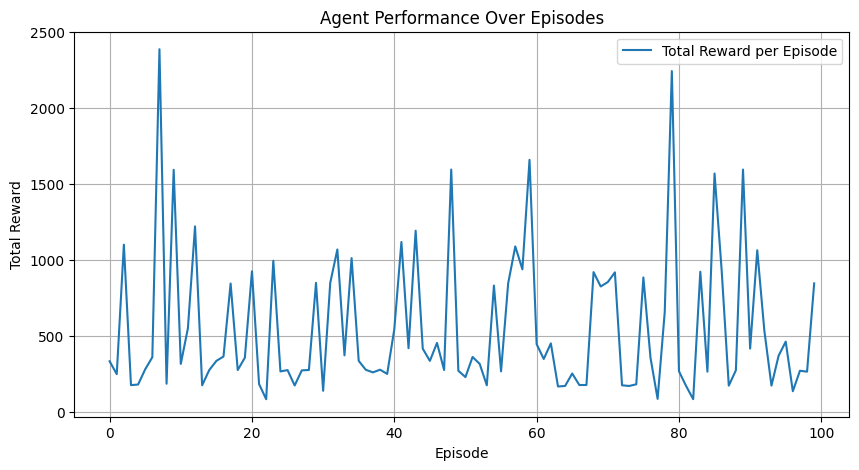

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# Initialize lists to store rewards and episode data
episode_rewards = []

# Train the SAC model with logging
for episode in range(100):
    obs, info = wrapped_env.reset()
    episode_reward = 0
    done = False

    while not done:
        action, _ = sac_model.predict(obs, deterministic=True)
        step_result = wrapped_env.step(action)  # Get the result of stepping in the environment

        if len(step_result) == 4:  # obs, reward, done, info
            obs, reward, done, info = step_result
        elif len(step_result) == 3:  # obs, reward, done
            obs, reward, done = step_result
            info = {}  # Provide an empty dictionary if no info is available
        elif len(step_result) == 5:  # obs, reward, done, info, extra
            obs, reward, done, info, extra = step_result

        episode_reward += reward

    episode_rewards.append(episode_reward)  # Log total reward for the episode

# Plotting total rewards per episode
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Agent Performance Over Episodes')
plt.legend()
plt.grid()
plt.show()


**PPO** **Implementation**

In [10]:
!pip install tensorboard


In [12]:
import grid2op
from grid2op.Reward import CombinedScaledReward

# Create the environment using Grid2Op
env = grid2op.make("l2rpn_case14_sandbox")



In [13]:
import grid2op
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from grid2op.Agent import DoNothingAgent  # Importing a default agent for reference

# Create the environment using Grid2Op
env = grid2op.make("l2rpn_case14_sandbox")  # Initialising the grid environment

# Define the PPO Actor-Critic architecture
class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 128)  # Second fully connected layer
        self.action_head = nn.Linear(128, action_dim)  # Output layer for action probabilities
        self.value_head = nn.Linear(128, 1)  # Output layer for state value estimation

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for the first layer
        x = torch.relu(self.fc2(x))  # Activation function for the second layer
        action_probs = torch.softmax(self.action_head(x), dim=-1)  # Softmax for action probabilities
        state_value = self.value_head(x)  # State value estimation
        return action_probs, state_value  # Returning both action probabilities and state value

# PPO Training Loop
def train_ppo(env_name, max_episodes=1000):
    env = grid2op.make(env_name)  # Create the Grid2Op environment

    input_dim = env.observation_space.size_obs()  # Get the size of the observation space
    action_dim = env.action_space.size()  # Get the size of the action space

    model = ActorCritic(input_dim, action_dim).to(device)  # Initialise the Actor-Critic model
    optimizer = optim.Adam(model.parameters(), lr=3e-4)  # Adam optimizer for training

    for episode in range(max_episodes):
        state = env.reset()  # Reset the environment to start a new episode
        state = state.to_vect()  # Convert the observation to a vector format

        done = False  # Flag to indicate the episode's end
        episode_reward = 0  # Cumulative reward for the episode

        while not done:
            state_tensor = torch.FloatTensor(state).to(device)  # Convert state to tensor

            # Forward pass through the model to get action probabilities and state value
            action_probs, state_value = model(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)  # Categorical distribution for actions
            action_idx = action_dist.sample().item()  # Sample an action index

            # Sample a valid action from the environment
            action = env.action_space.sample()  # Sample a valid Grid2Op action

            next_state, reward, done, _ = env.step(action)  # Step the environment with the selected action
            next_state = next_state.to_vect()  # Convert the next state to vector format

            episode_reward += reward  # Accumulate the reward
            state = next_state  # Update the current state

        print(f"Episode {episode + 1}: Total Reward: {episode_reward}")  # Log the total reward for the episode

# Run PPO training
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA or CPU
    train_ppo("l2rpn_case14_sandbox")  # Call the training function


Episode 1: Total Reward: 173.55820846557617
Episode 2: Total Reward: 188.02920532226562
Episode 3: Total Reward: -10.0
Episode 4: Total Reward: 56.363311767578125
Episode 5: Total Reward: 433.9375114440918
Episode 6: Total Reward: 170.37131881713867
Episode 7: Total Reward: -10.0
Episode 8: Total Reward: 253.93328857421875
Episode 9: Total Reward: 117.92374801635742
Episode 10: Total Reward: 121.3549575805664
Episode 11: Total Reward: 52.674407958984375
Episode 12: Total Reward: 53.34950256347656
Episode 13: Total Reward: 445.3385124206543
Episode 14: Total Reward: 324.6808547973633
Episode 15: Total Reward: 245.3737678527832
Episode 16: Total Reward: 375.76385498046875
Episode 17: Total Reward: 303.0628204345703
Episode 18: Total Reward: -10.0
Episode 19: Total Reward: 356.51268005371094
Episode 20: Total Reward: 231.76951217651367
Episode 21: Total Reward: 358.0327949523926
Episode 22: Total Reward: -10.0
Episode 23: Total Reward: -10.0
Episode 24: Total Reward: 119.23004150390625
Ep

**CombinedScaledReward**

Episode 1: Total Combined Reward: 403.5
Episode 2: Total Combined Reward: 1500.5
Episode 3: Total Combined Reward: 1.5
Episode 4: Total Combined Reward: 402.0
Episode 5: Total Combined Reward: 256.5
Episode 6: Total Combined Reward: 636.0
Episode 7: Total Combined Reward: 630.5
Episode 8: Total Combined Reward: 240.0
Episode 9: Total Combined Reward: 1411.0
Episode 10: Total Combined Reward: 257.5
Episode 11: Total Combined Reward: 1354.5
Episode 12: Total Combined Reward: 482.0
Episode 13: Total Combined Reward: 546.5
Episode 14: Total Combined Reward: 545.0
Episode 15: Total Combined Reward: 401.0
Episode 16: Total Combined Reward: 689.0
Episode 17: Total Combined Reward: 2272.0
Episode 18: Total Combined Reward: 2277.0
Episode 19: Total Combined Reward: 259.0
Episode 20: Total Combined Reward: 259.5
Episode 21: Total Combined Reward: 547.5
Episode 22: Total Combined Reward: 548.0
Episode 23: Total Combined Reward: 398.5
Episode 24: Total Combined Reward: 547.0
Episode 25: Total Comb

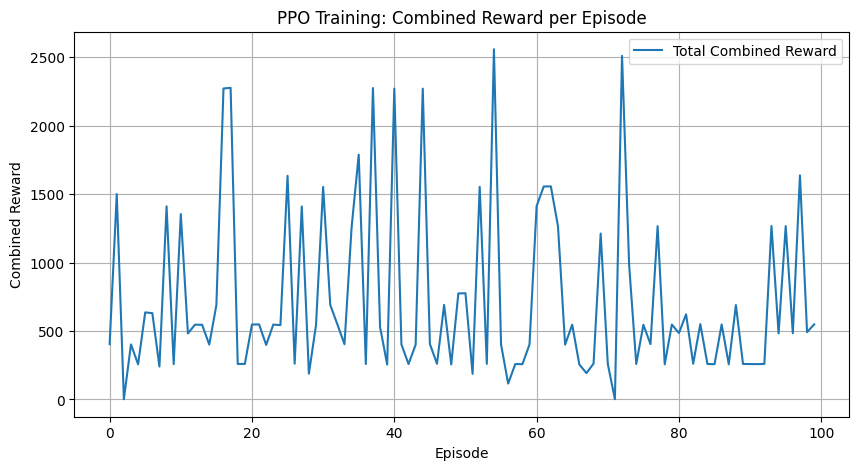

In [14]:
import grid2op
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
from grid2op.Reward import CombinedScaledReward  # Importing the CombinedScaledReward for optimising the agent's performance

# Define the PPO Actor-Critic architecture
class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 128)  # Second fully connected layer
        self.action_head = nn.Linear(128, action_dim)  # Output layer for action probabilities
        self.value_head = nn.Linear(128, 1)  # Output layer for state value estimation

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for the first layer
        x = torch.relu(self.fc2(x))  # Activation function for the second layer
        action_probs = torch.softmax(self.action_head(x), dim=-1)  # Softmax for action probabilities
        state_value = self.value_head(x)  # State value estimation
        return action_probs, state_value  # Returning both action probabilities and state value

def train_ppo(env_name, max_episodes=100):
    env = grid2op.make(env_name)  # Create the Grid2Op environment

    input_dim = env.observation_space.size_obs()  # Observation size
    action_dim = env.action_space.size()  # Action size

    model = ActorCritic(input_dim, action_dim).to(device)  # Initialise the Actor-Critic model
    optimizer = optim.Adam(model.parameters(), lr=3e-4)  # Adam optimizer for training

    # Initialise the CombinedScaledReward
    custom_reward = CombinedScaledReward()  # Create an instance of the combined reward class

    rewards_per_episode = []  # List to store rewards for each episode

    for episode in range(max_episodes):
        state = env.reset()  # Reset the environment
        state = state.to_vect()  # Convert to vector format
        done = False  # Flag to indicate the episode's end
        episode_reward = 0  # Cumulative reward for the episode

        while not done:
            state_tensor = torch.FloatTensor(state).to(device)  # Convert state to tensor
            action_probs, state_value = model(state_tensor)  # Forward pass to get action probabilities
            action_dist = torch.distributions.Categorical(action_probs)  # Categorical distribution for actions
            action_idx = action_dist.sample().item()  # Sample an action index

            # Create action vector based on action index
            action_vector = np.zeros(action_dim)  # Create a zero vector for the action space
            action_vector[action_idx] = 1  # Set the selected action index to 1

            # Convert action vector to a valid Grid2Op action
            grid2op_action = env.action_space({})  # Initialise action space
            grid2op_action._dispatch = action_vector  # Assign the action vector to the action object

            try:
                next_state, reward, done, info = env.step(grid2op_action)  # Use the action object

                # Use required parameters for the CombinedScaledReward
                is_illegal = info.get("is_illegal", False)  # Check if the action was illegal
                is_ambiguous = info.get("is_ambiguous", False)  # Check if the action was ambiguous

                # Calculate the reward using the custom reward function
                reward = custom_reward(action_vector, state, next_state, done, is_illegal, is_ambiguous)

                next_state = next_state.to_vect()  # Convert next state to vector format
            except grid2op.Exceptions.Grid2OpException as e:
                print(f"Error during step: {e}")  # Log any error encountered
                done = True  # End episode on backend error
                env.reset()  # Force reset after backend error

            episode_reward += reward  # Accumulate the reward
            state = next_state  # Update the current state

        rewards_per_episode.append(episode_reward)  # Store the total reward for the episode
        print(f"Episode {episode + 1}: Total Combined Reward: {episode_reward}")  # Log the total reward for the episode

    # Save the PPO model after training
    torch.save(model.state_dict(), "ppo_grid2op_agent_combined.pth")  # Save model weights

    # Plot the rewards over episodes
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_per_episode, label='Total Combined Reward')
    plt.xlabel('Episode')
    plt.ylabel('Combined Reward')
    plt.title('PPO Training: Combined Reward per Episode')
    plt.legend()
    plt.grid()
    plt.savefig("ppo_combined_reward_plot.png")  # Save the plot as an image file
    plt.show()  # Display the plot

# Main loop
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set the device to CUDA or CPU
    train_ppo("l2rpn_case14_sandbox")  # Call the training function


In [ ]:
from google.colab import files

# Download the saved model file
files.download("ppo_grid2op_agent_combined.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Evaluation** **of** **the** **model**

In [15]:
def evaluate_model(env_name, model_path, num_episodes=10):
    # Create the environment
    env = grid2op.make(env_name)

    # Load the trained model
    model = ActorCritic(input_dim=env.observation_space.size_obs(), action_dim=env.action_space.size())
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load model on the correct device
    model.to(device)  # Move model to the specified device
    model.eval()  # Set the model to evaluation mode

    total_rewards = []  # To store total rewards for each episode

    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment
        state = state.to_vect()  # Convert to vector format
        done = False
        episode_reward = 0

        while not done:
            # Prepare the state tensor and move it to the device
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs, _ = model(state_tensor)  # Get action probabilities
            action_dist = torch.distributions.Categorical(action_probs)
            action_idx = action_dist.sample().item()  # Sample an action

            action = env.action_space.sample()  # Sample a valid action based on action_idx

            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state.to_vect()  # Update the state

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Total Reward: {episode_reward}")

    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"Mean Reward over {num_episodes} episodes: {mean_reward} ± {std_reward}")

# Main evaluation loop
if __name__ == "__main__":
    model_path = "ppo_grid2op_agent_combined.pth"  # Path to the saved model
    evaluate_model("l2rpn_case14_sandbox", model_path, num_episodes=10)


<ipython-input-15-6880b9a55d66>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))  # Load model on the corr

Episode 1: Total Reward: -10.0
Episode 2: Total Reward: -10.0
Episode 3: Total Reward: -10.0
Episode 4: Total Reward: 379.5588150024414
Episode 5: Total Reward: 52.83698654174805
Episode 6: Total Reward: 414.79048919677734
Episode 7: Total Reward: 118.82476806640625
Episode 8: Total Reward: 56.194618225097656
Episode 9: Total Reward: -10.0
Episode 10: Total Reward: 318.4690704345703
Mean Reward over 10 episodes: 130.0674747467041 ± 163.96097727754804


**PPO Evaluation plot**

<ipython-input-16-b26619943677>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Episode 1: Total Reward: 54.308685302734375
Episode 2: Total Reward: 317.42760467529297
Episode 3: Total Reward: 175.92142868041992
Episode 4: Total Reward: 653.7867431640625
Episode 5: Total Reward: 239.88191986083984
Episode 6: Total Reward: 49.33806228637695
Episode 7: Total Reward: 185.93126678466797
Episode 8: Total Reward: 188.13946533203125
Episode 9: Total Reward: 180.5320053100586
Episode 10: Total Reward: 121.1014175415039
Mean Reward over 10 episodes: 216.63685989379883 ± 164.31120290183702


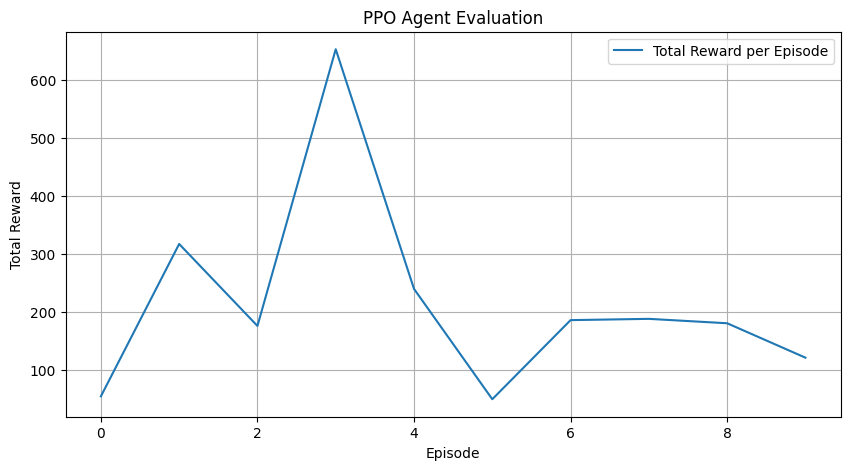

In [16]:
import matplotlib.pyplot as plt

# Store total rewards for plotting
total_rewards = []

def evaluate_model(env_name, model_path, num_episodes=10):
    env = grid2op.make(env_name)
    model = ActorCritic(input_dim=env.observation_space.size_obs(), action_dim=env.action_space.size())
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    for episode in range(num_episodes):
        state = env.reset()
        state = state.to_vect()
        done = False
        episode_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state).to(device)
            action_probs, _ = model(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action_idx = action_dist.sample().item()
            action = env.action_space.sample()  # Sample action

            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            state = next_state.to_vect()

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Total Reward: {episode_reward}")

    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"Mean Reward over {num_episodes} episodes: {mean_reward} ± {std_reward}")

    # Plotting the rewards
    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('PPO Agent Evaluation')
    plt.legend()
    plt.grid()
    plt.show()

# Main evaluation loop
if __name__ == "__main__":
    model_path = "ppo_grid2op_agent_combined.pth"  # Path to the saved model
    evaluate_model("l2rpn_case14_sandbox", model_path, num_episodes=10)
